<a href="https://colab.research.google.com/github/marty916/AI-Training-Colab-Notebooks/blob/main/IBM-SkillsBuild-Program-in-Artificial-Intelligence/Session3_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [2]:

# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))



11490434/11490434 [==============================] - 2s 0us/step


In [3]:
# Encoder
latent_dim = 2
encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)



In [4]:
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])



In [5]:
# Decoder
decoder_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)



In [6]:
# VAE Model
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')
outputs = decoder(encoder(encoder_inputs)[2])
vae = tf.keras.Model(encoder_inputs, outputs, name='vae')



In [7]:
# VAE loss
reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(encoder_inputs), tf.keras.backend.flatten(outputs))
reconstruction_loss *= 28 * 28
kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')



In [8]:
# Train the model
vae.fit(x_train, epochs=30, batch_size=128, validation_data=(x_test, None))



Epoch 1/30
469/469 [==============================] - 12s 8ms/step - loss: 220.1320 - val_loss: 192.7426
Epoch 2/30
469/469 [==============================] - 3s 6ms/step - loss: 189.9009 - val_loss: 186.7268
Epoch 3/30
469/469 [==============================] - 3s 6ms/step - loss: 185.7549 - val_loss: 183.8112
Epoch 4/30
469/469 [==============================] - 3s 6ms/step - loss: 183.8855 - val_loss: 182.2650
Epoch 5/30
469/469 [==============================] - 3s 6ms/step - loss: 182.5028 - val_loss: 180.6030
Epoch 6/30
469/469 [==============================] - 3s 6ms/step - loss: 181.2126 - val_loss: 179.3304
Epoch 7/30
469/469 [==============================] - 3s 6ms/step - loss: 179.8940 - val_loss: 177.9149
Epoch 8/30
469/469 [==============================] - 3s 6ms/step - loss: 178.7249 - val_loss: 177.3615
Epoch 9/30
469/469 [==============================] - 3s 6ms/step - loss: 177.7983 - val_loss: 176.0905
Epoch 10/30
469/469 [==============================] - 3s 6ms/s

In [9]:
# Display generated images
def plot_latent_space(decoder, n=30, figsize=15):
    # Display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # Linearly spaced coordinates on the unit square were transformed
    # through the inverse CDF (ppf) of the Gaussian to produce values
    # of the latent variables z, since the prior of the latent space
    # is Gaussian
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()


1/1 [==============================] - 0s 20ms/step


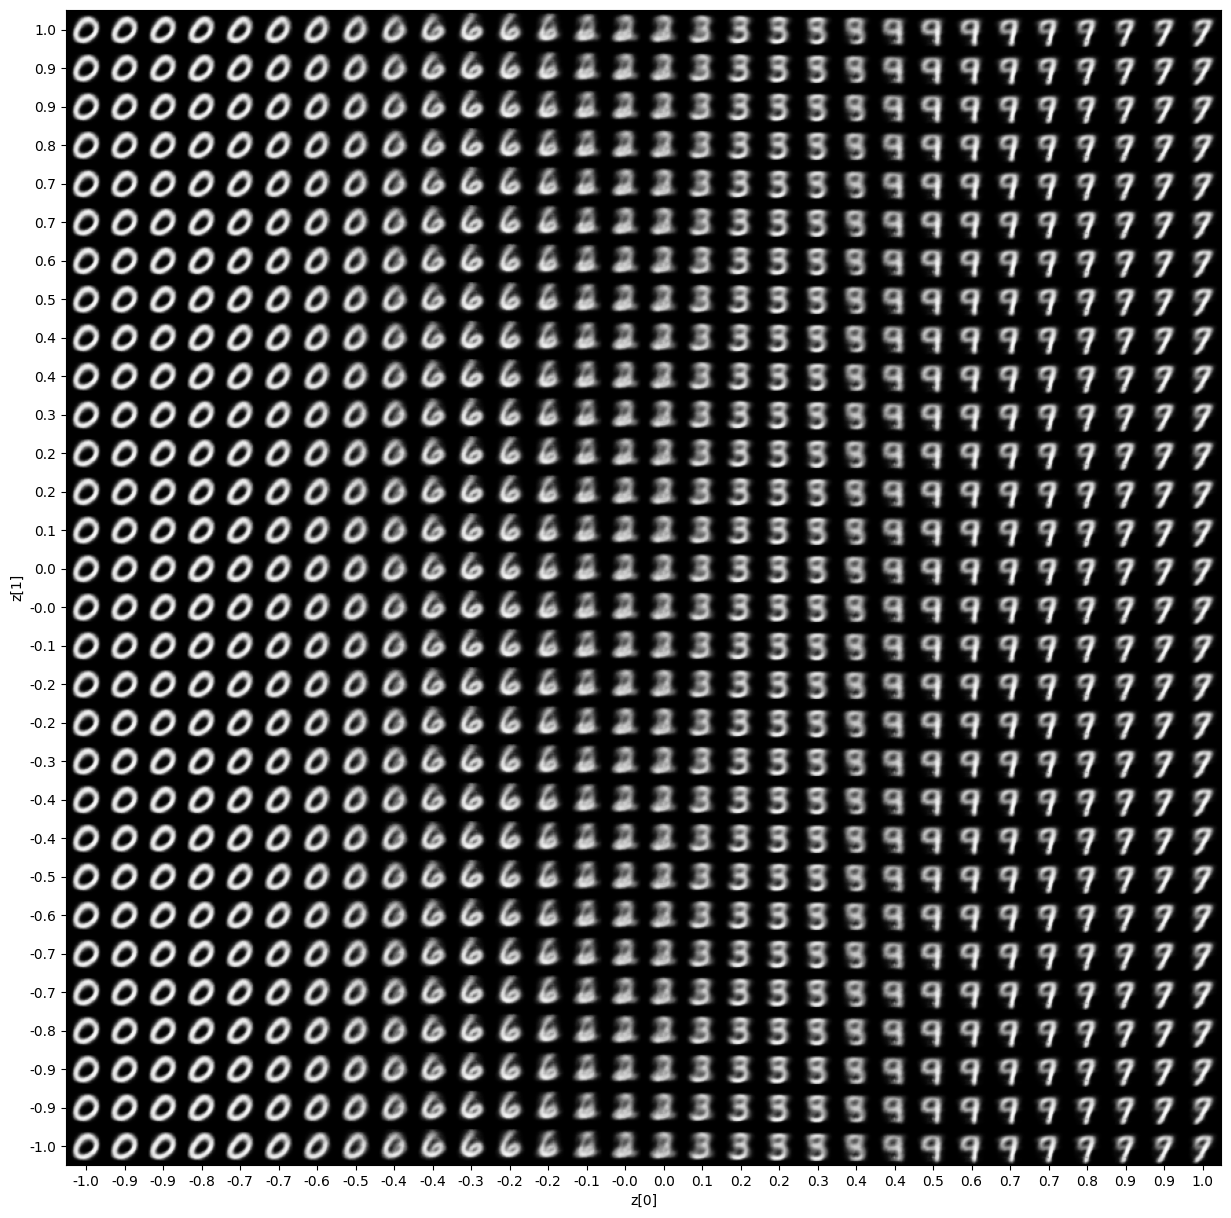

In [10]:
# run the model
plot_latent_space(decoder)
